In [1]:
# Cell 1 – libraries
import numpy as np
from numpy import exp, log, sqrt
from scipy.stats import norm, qmc
from tqdm.auto import trange
import matplotlib.pyplot as plt


In [18]:
# Cell 2 – Sobol Monte-Carlo simulator for the HHK electricity-spot model
def HHKSim(
        S0: float,
        X0: float,
        Y0: float,
        alpha: float,
        beta: float,
        sigma: float,
        lam: float,
        mu_J: float,
        f_func,
        dt: float,
        T_steps: int,
        N_paths: int,
        assume_one_jump_per_dt: bool = True,
        _show_progress: bool = True,
        seed: int | None = None
    ):
    """
    Simulates the Hambly–Howison–Kluge spike-diffusion electricity model.

    Parameters
    ----------
    S0 : float
        Initial spot price.
    X0 : float
        Initial OU level.
    Y0 : float
        Initial spike level.
    alpha : float
        Mean-reversion rate of X (diffusive part).
    beta : float
        Mean-reversion rate of Y (spike part).
    sigma : float
        Diffusive volatility parameter.
    lam : float
        Poisson jump intensity λ.
    mu_J : float
        Mean jump size μ_J (J ~ Exp(1/μ_J)).
    f_func : callable
        Deterministic seasonality  f(t).
    dt : float
        Time increment.
    T_steps : int
        Number of time steps.
    N_paths : int
        Number of simulated paths (power of two recommended).
    assume_one_jump_per_dt : bool, optional
        If True (default) use Bernoulli λ dt for jump arrival.
        Works well for small dt; decrease dt if λ dt ≳ 0.1.
    _show_progress : bool, optional
        Display tqdm progress bar.
    seed : int | None, optional
        Seed for Sobol scrambling.

    Returns
    -------
    S : ndarray
        Spot price paths, shape (N_paths, T_steps+1).
    X : ndarray
        Diffusive component, shape (N_paths, T_steps+1).
    Y : ndarray
        Spike component, shape (N_paths, T_steps+1).
    """
    # --- pre-checks ---------------------------------------------------------
    assert np.log2(N_paths).is_integer(), "N_paths should be a power of two for Sobol quality."
    assert dt > 0 and T_steps > 0

    # --- pre-compute constants ---------------------------------------------
    E_alpha = exp(-alpha*dt)
    E_beta  = exp(-beta*dt)
    var_X   = sigma**2/(2*alpha)*(1 - exp(-2*alpha*dt))
    p_jump  = 1.0 - exp(-lam*dt)                 # jump probability per step

    # --- Sobol sequence -----------------------------------------------------
    # need three uniforms per step: Z (Brownian), U1 (jump yes/no), U2 (jump size)
    dim = 3*T_steps
    sampler = qmc.Sobol(d=dim, scramble=True, seed=seed)
    U_mat   = sampler.random(n=N_paths)          # shape (N_paths , dim)

    # unpack Sobol coordinates
    Z_norm = norm.ppf(U_mat[:, 0*T_steps:1*T_steps])   # Brownian increments
    U_evt  = U_mat[:, 1*T_steps:2*T_steps]             # jump occurrence
    U_jmp  = U_mat[:, 2*T_steps:3*T_steps]             # jump size uniforms

    # transpose for vectorised time loop: shape (T_steps, N_paths)
    Z_norm, U_evt, U_jmp = Z_norm.T, U_evt.T, U_jmp.T

    # --- containers ---------------------------------------------------------
    S = np.empty((T_steps+1, N_paths))
    X = np.empty_like(S)
    Y = np.empty_like(S)

    S[0] = S0
    X[0] = X0
    Y[0] = Y0

    # --- main simulation loop ----------------------------------------------
    for t in trange(1, T_steps+1, desc="Simulating HHK paths",
                    disable=not _show_progress):
        # OU diffusion -------------------------------------------------------
        X[t] = X[t-1]*E_alpha + sqrt(var_X)*Z_norm[t-1]

        # Spike process ------------------------------------------------------
        if assume_one_jump_per_dt:
            jumps   = (U_evt[t-1] < p_jump)                    # boolean mask
            J_size  = -mu_J * np.log(1.0 - U_jmp[t-1])         # exponential
            Y[t]    = Y[t-1]*E_beta + jumps*J_size
        else:
            # generic Poisson count using inverse-CDF on a Sobol uniform
            counts  = np.floor(-np.log(1.0-U_evt[t-1])/ (lam*dt)).astype(int)
            J_size  = -mu_J * np.log(1.0 - U_jmp[t-1])
            Y[t]    = Y[t-1]*E_beta + counts*J_size

        # Spot price ---------------------------------------------------------
        S[t] = exp(f_func(t*dt) + X[t] + Y[t])
        # S[t] = exp(X[t] + Y[t])

    # reshape to (N_paths, T_steps+1) ---------------------------------------
    S = S.T
    X = X.T
    Y = Y.T
    return S, X, Y


Simulating HHK paths:   0%|          | 0/30 [00:00<?, ?it/s]

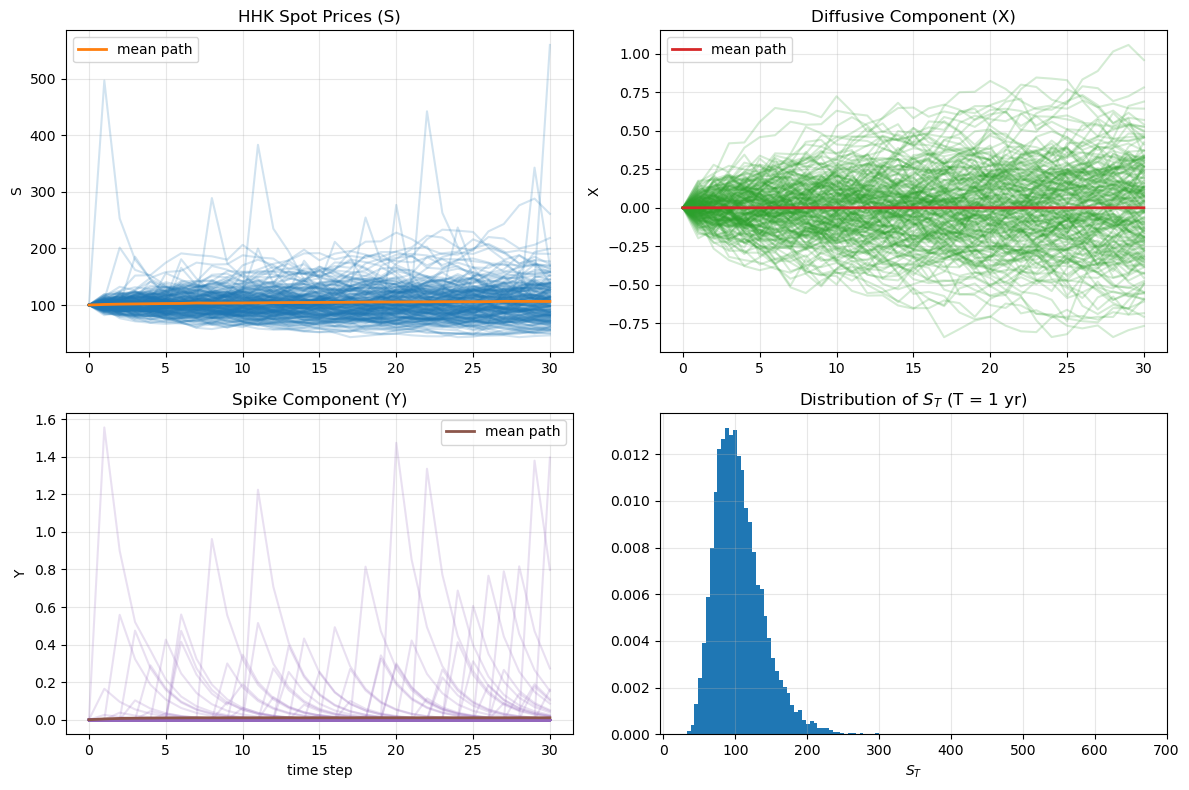

In [29]:
# Cell 3 – run a quick test with the paper’s baseline parameters
# Parameters from Hambly–Howison–Kluge, Fig. 1
f = lambda tau: np.log(100.0) + 0.5*np.cos(2*np.pi*tau)   # deterministic seasonality
f = lambda tau: np.log(100.0)
params = dict(
    S0=100.0, X0=0.0, Y0=0.0,    # initial values
    alpha=7.0, beta=200.0,
    sigma=1.4,
    lam=4.0,
    mu_J=0.4,
    f_func=f,
    dt=1/365,                    # daily steps
    T_steps=30,                 # one-year horizon
    N_paths=2**14,               # 2**14=16384 paths
    seed=42
)

S, X, Y = HHKSim(**params)


# Plot S, X, Y in a 3x1 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot S (spot prices)
axes[0, 0].grid(True, alpha=0.3, zorder=0)
axes[0, 0].plot(S[:200, :].T, alpha=0.2, color='tab:blue')
axes[0, 0].plot(S.mean(axis=0), color='tab:orange', linewidth=2, label="mean path")
axes[0, 0].set_title("HHK Spot Prices (S)")
axes[0, 0].set_ylabel("S")
axes[0, 0].legend()

# Plot X (diffusive component)
axes[0, 1].grid(True, alpha=0.3, zorder=0)
axes[0, 1].plot(X[:200, :].T, alpha=0.2, color='tab:green')
axes[0, 1].plot(X.mean(axis=0), color='tab:red', linewidth=2, label="mean path")
axes[0, 1].set_title("Diffusive Component (X)")
axes[0, 1].set_ylabel("X")
axes[0, 1].legend()

# Plot Y (spike component)
axes[1, 0].grid(True, alpha=0.3, zorder=0)
axes[1, 0].plot(Y[:200, :].T, alpha=0.2, color='tab:purple')
axes[1, 0].plot(Y.mean(axis=0), color='tab:brown', linewidth=2, label="mean path")
axes[1, 0].set_title("Spike Component (Y)")
axes[1, 0].set_xlabel("time step")
axes[1, 0].set_ylabel("Y")
axes[1, 0].legend()

axes[1, 1].grid(True, alpha=0.3, zorder=0)
axes[1, 1].hist(S[:, -1], bins=120, density=True)
axes[1, 1].set_title("Distribution of $S_T$ (T = 1 yr)")
axes[1, 1].set_xlabel("$S_T$")

plt.tight_layout()
plt.show()
